In [1]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, ZeroPadding2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_path = '/kaggle/input/pkl-brightconn-gamma-dataset'
data_dir = os.path.join(base_path, 'to_train')

dataset_path = os.path.join(data_dir, 'preprocessed')
train_path = os.path.join(data_dir, 'training')
valid_path = os.path.join(data_dir, 'validation')
testing_path = os.path.join(data_dir, 'testing')

In [3]:
img_height, img_width = 224, 224
validation_split=0.2

In [4]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset='training',
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
)

Found 2064 files belonging to 19 classes.
Using 1652 files for training.


In [5]:
validate_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    seed=123,
    subset='validation',
    label_mode='categorical',
    image_size=(img_height, img_width),
)

Found 2064 files belonging to 19 classes.
Using 412 files for validation.


In [6]:
def residual_block(x, filters, stride=1, use_projection=False):
    identity = x

    # First convolution layer in the block
    x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer in the block
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution layer in the block
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # Projection shortcut for identity
    if use_projection:
        identity = Conv2D(filters * 4, kernel_size=(1, 1), strides=stride, padding='valid')(identity)
        identity = BatchNormalization()(identity)

    # Adding the identity (skip connection) to the output
    x = Add()([x, identity])
    x = ReLU()(x)

    return x

In [7]:
def build_resnet101(dropout, input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)
    
    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(22):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    if dropout != 0:
        x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet101')

    return model

In [8]:
def build_resnet50(dropout, input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(5):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    if dropout != 0:
        x = tf.keras.layers.Dropout(dropout)(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet50')

    return model

In [9]:
def print_history(history, epoch):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.axis([0, epoch, 0, max(history.history['val_accuracy'])])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.axis([0, epoch, 0, max(history.history['val_loss'])])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    plt.show()

In [10]:
output_dir = '/kaggle/working/'
model_resnet101 = os.path.join(output_dir, 'resnet101_pkl_brightconn_gamma.h5')
model_resnet50 = os.path.join(output_dir, 'resnet50_pkl_brightconn_gamma.h5')

save_model_101 = tf.keras.callbacks.ModelCheckpoint(
   model_resnet101,
   monitor='val_accuracy', 
   save_best_only=True, 
   mode='max', 
   verbose=1
)
save_model_50 = tf.keras.callbacks.ModelCheckpoint(
   model_resnet50,
   monitor='val_accuracy', 
   save_best_only=True, 
   mode='max', 
   verbose=1
)

In [11]:
def build_101(batch_size, epoch, learning_rate, dropout):
    resnet101 = build_resnet101(dropout=dropout)
    resnet101.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    history = resnet101.fit(
      train_gen,
      epochs=epoch,
      validation_data=validate_gen,
      batch_size=batch_size,
      callbacks=[save_model_101]
    )
    print_history(history, epoch)
    return resnet101

In [12]:
def build_50(batch_size, epoch, learning_rate, dropout):
    model = build_resnet50(dropout=dropout)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
      train_gen,
      epochs=epoch,
      validation_data=validate_gen,
      batch_size=batch_size,
      callbacks=[save_model_50]
    )
    print_history(history, epoch)
    return model

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 3.2594 - accuracy: 0.0890
Epoch 1: val_accuracy improved from -inf to 0.05097, saving model to /kaggle/working/resnet101_pkl_brightconn_gamma.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 98s 428ms/step - loss: 3.2594 - accuracy: 0.0890 - val_loss: 2.9481 - val_accuracy: 0.0510
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 2.9345 - accuracy: 0.1211
Epoch 2: val_accuracy did not improve from 0.05097
52/52 [==============================] - 16s 306ms/step - loss: 2.9345 - accuracy: 0.1211 - val_loss: 2.9637 - val_accuracy: 0.0485
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 2.8749 - accuracy: 0.1186
Epoch 3: val_accuracy improved from 0.05097 to 0.06311, saving model to /kaggle/working/resnet101_pkl_brightconn_gamma.h5
52/52 [==============================] - 18s 350ms/step - loss: 2.8749 - accuracy: 0.1186 - val_loss: 2.9856 - val_accuracy: 0.0631
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 2.8532 - accuracy: 0.1326
Epoch 4: val_accuracy improved from 0.06311 to 0.06796, saving model to /kaggle/working/resnet101_pkl_brightconn_gamma.h5
52/52 [=================

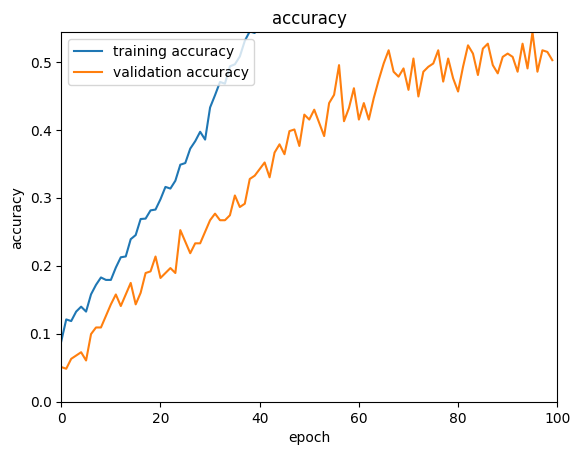

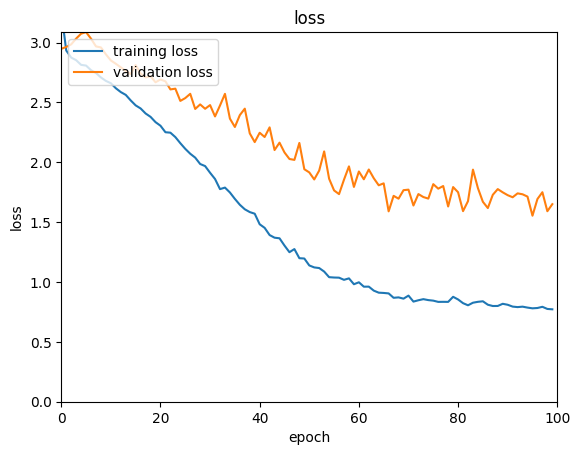

In [13]:
model_101 = build_101(8, 100, 0.00001, 0)

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 3.0797 - accuracy: 0.0962
Epoch 1: val_accuracy improved from -inf to 0.06068, saving model to /kaggle/working/resnet50_pkl_brightconn_gamma.h5
52/52 [==============================] - 47s 228ms/step - loss: 3.0797 - accuracy: 0.0962 - val_loss: 2.9409 - val_accuracy: 0.0607
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 2.9045 - accuracy: 0.1186
Epoch 2: val_accuracy did not improve from 0.06068
52/52 [==============================] - 10s 189ms/step - loss: 2.9045 - accuracy: 0.1186 - val_loss: 2.9568 - val_accuracy: 0.0485
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 2.8207 - accuracy: 0.1350
Epoch 3: val_accuracy did not improve from 0.06068
52/52 [==============================] - 10s 189ms/step - loss: 2.8207 - accuracy: 0.1350 - val_loss: 2.9988 - val_accuracy: 0.0510
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 2.7774 - accuracy: 0.1483
Epoc

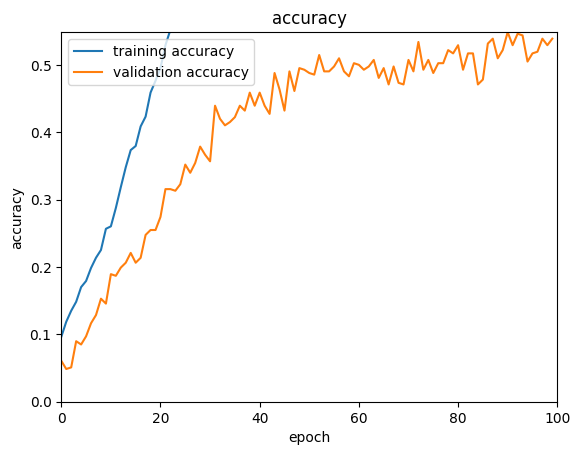

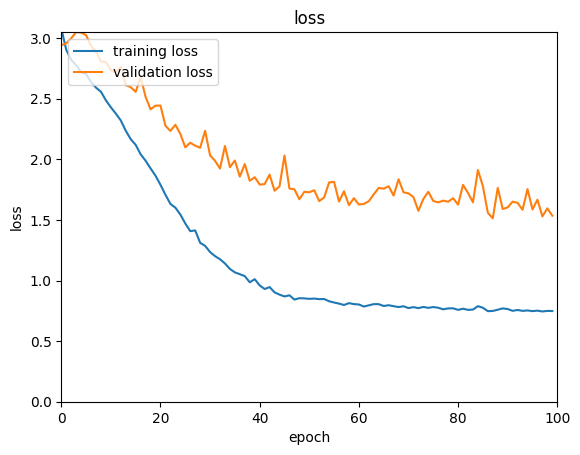

In [14]:
model_50 = build_50(8, 100, 0.00001, 0)

In [15]:
resnet101 = keras.models.load_model(model_resnet101)
resnet50 = keras.models.load_model(model_resnet50)

In [18]:
class_names = train_gen.class_names
num_classes = len(class_names)
class_dict = {}
i = 0
for classes in class_names:
   class_dict[classes] = i
   i += 1

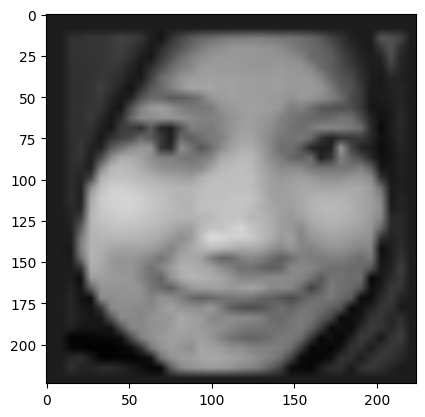

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051051_face_2017051051_20221230_Masuk_48.png
Prediksi 101:  2017051051
Prediksi 50:  2017051051
Probabilitas 101:  0.9963130354881287
Probabilitas 50:  0.951073944568634




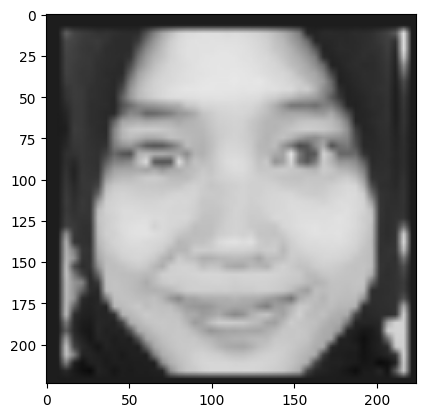

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051031_face_2017051031_20221227_Masuk_15.png
Prediksi 101:  2017051031
Prediksi 50:  2017051031
Probabilitas 101:  0.9619154930114746
Probabilitas 50:  0.5340327024459839




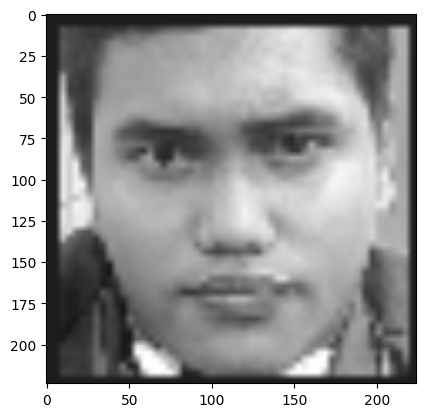

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051033_face_2017051033_20221226_Pulang Cepat_26.png
Prediksi 101:  2017051014
Prediksi 50:  2017051014
Probabilitas 101:  0.7544143199920654
Probabilitas 50:  0.8520875573158264




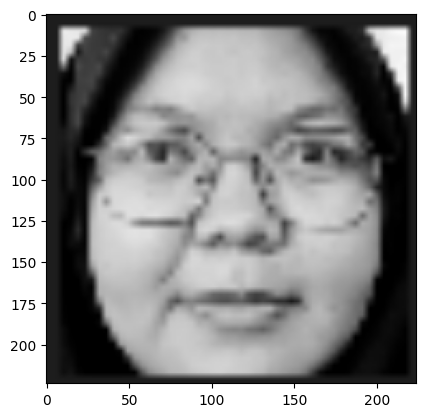

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051016_face_2017051016_20221229_Masuk_1.png
Prediksi 101:  2017051016
Prediksi 50:  2017051016
Probabilitas 101:  0.9824239611625671
Probabilitas 50:  0.8009682893753052




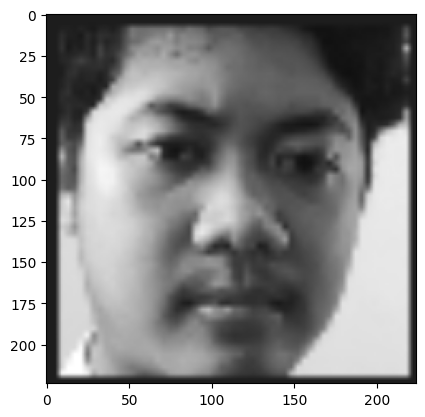

1/1 [==============================] - 0s 22ms/step
Nama File:  2057051003_face_2057051003_20221228_Pulang_41.png
Prediksi 101:  2057051003
Prediksi 50:  2057051003
Probabilitas 101:  0.9753614664077759
Probabilitas 50:  0.6235730648040771




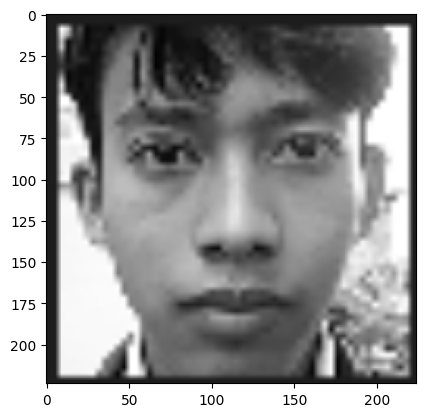

1/1 [==============================] - 0s 27ms/step
Nama File:  2017051026_face_2017051026_20221230_Pulang_88.png
Prediksi 101:  2017051044
Prediksi 50:  2017051044
Probabilitas 101:  0.5037732124328613
Probabilitas 50:  0.8703160881996155




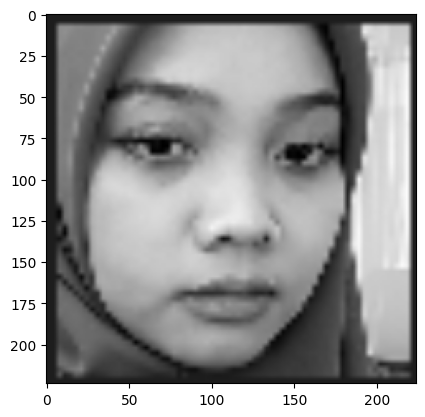

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051079_face_2017051079_20221228_Pulang_68.png
Prediksi 101:  2017051079
Prediksi 50:  2017051079
Probabilitas 101:  0.9997778534889221
Probabilitas 50:  0.999995231628418




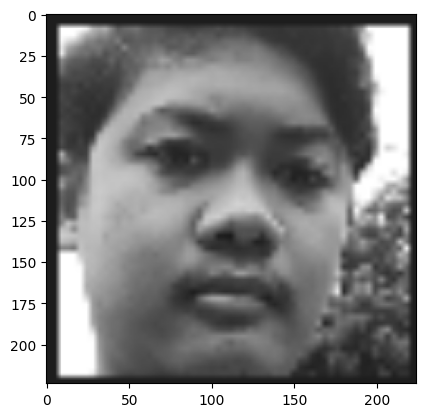

1/1 [==============================] - 0s 24ms/step
Nama File:  2057051003_face_2057051003_20221227_Masuk_21.png
Prediksi 101:  2057051003
Prediksi 50:  2017051033
Probabilitas 101:  0.6963790059089661
Probabilitas 50:  0.1748659759759903




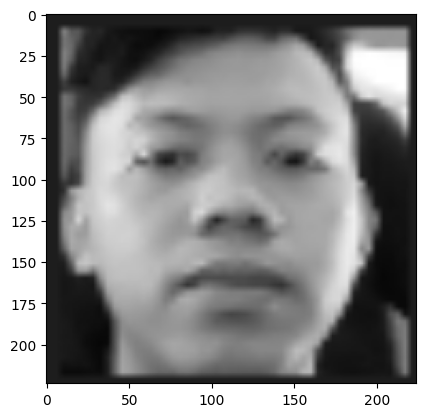

1/1 [==============================] - 0s 23ms/step
Nama File:  2017051020_face_2017051020_20221227_Pulang Cepat_68.png
Prediksi 101:  2017051020
Prediksi 50:  2017051020
Probabilitas 101:  0.9870170950889587
Probabilitas 50:  0.9893323183059692




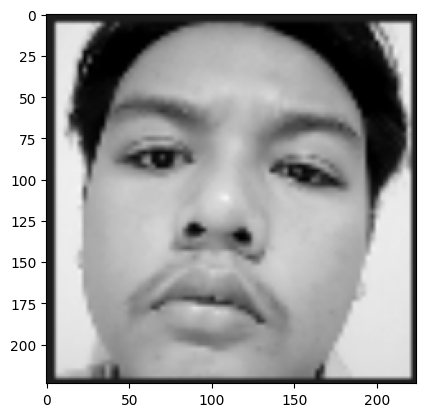

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051041_face_1917051041_20221229_Masuk_70.png
Prediksi 101:  1917051041
Prediksi 50:  1917051041
Probabilitas 101:  0.9783293604850769
Probabilitas 50:  0.9971024394035339




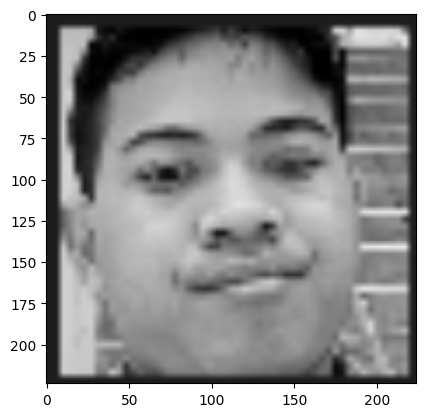

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051081_face_2017051081_20221227_Pulang_9.png
Prediksi 101:  2017051081
Prediksi 50:  2017051081
Probabilitas 101:  0.8907412886619568
Probabilitas 50:  0.9609962105751038




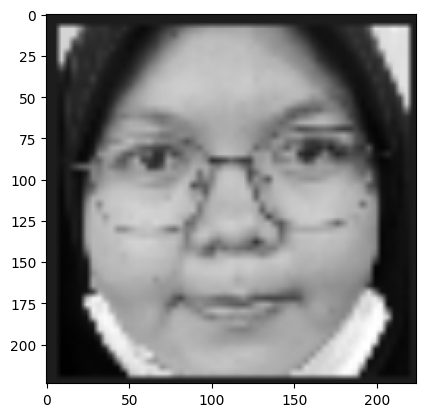

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051016_face_2017051016_20221227_Masuk_87.png
Prediksi 101:  2017051016
Prediksi 50:  2017051016
Probabilitas 101:  0.981046736240387
Probabilitas 50:  0.943000078201294




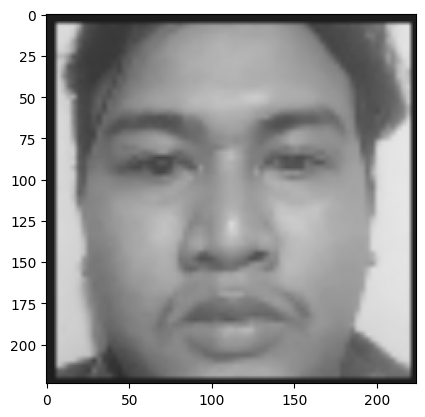

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051029_face_1917051029_20221229_Pulang_47.png
Prediksi 101:  1917051029
Prediksi 50:  1917051041
Probabilitas 101:  0.7919698357582092
Probabilitas 50:  0.48821818828582764




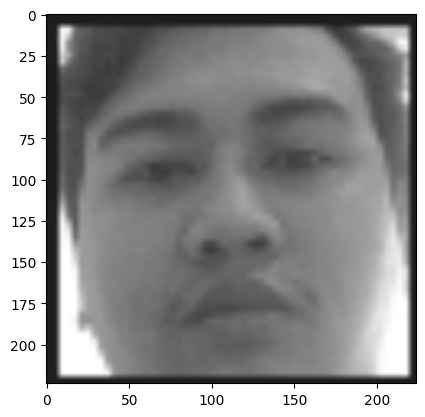

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051029_face_1917051029_20221226_Datang Terlambat_50.png
Prediksi 101:  1917051029
Prediksi 50:  1917051029
Probabilitas 101:  0.9820526242256165
Probabilitas 50:  0.9963856935501099




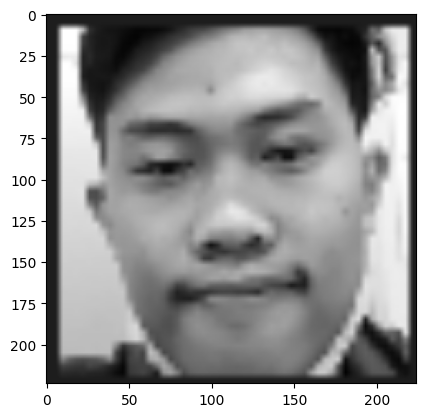

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051044_face_2017051044_20221230_Masuk_81.png
Prediksi 101:  2017051044
Prediksi 50:  2017051044
Probabilitas 101:  0.9899318218231201
Probabilitas 50:  0.8693071603775024




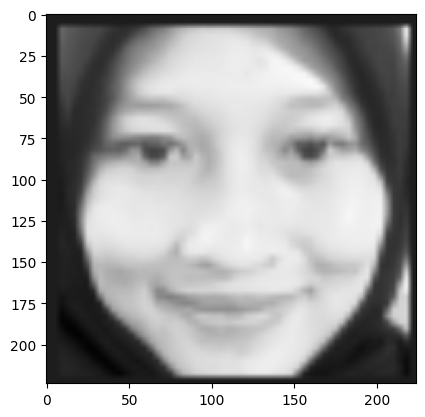

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051013_face_2017051013_20221227_Masuk_87.png
Prediksi 101:  2017051031
Prediksi 50:  2017051079
Probabilitas 101:  0.6073694825172424
Probabilitas 50:  0.5616307854652405




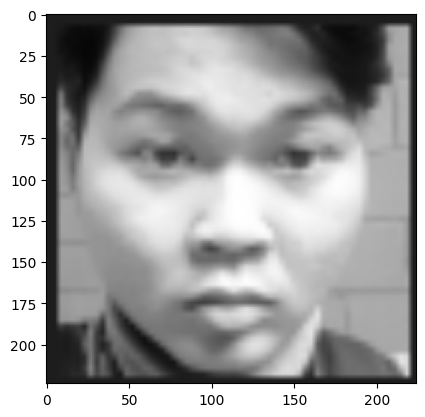

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051004_face_2017051004_20221227_Masuk_54.png
Prediksi 101:  2017051004
Prediksi 50:  2017051004
Probabilitas 101:  0.9209282398223877
Probabilitas 50:  0.9446665644645691




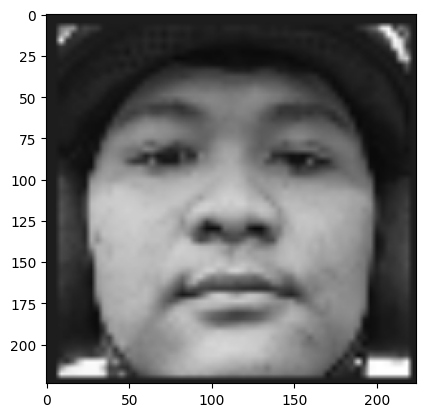

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051047_face_1917051047_20221227_Masuk_76.png
Prediksi 101:  2017051016
Prediksi 50:  2017051081
Probabilitas 101:  0.46237948536872864
Probabilitas 50:  0.8780245780944824




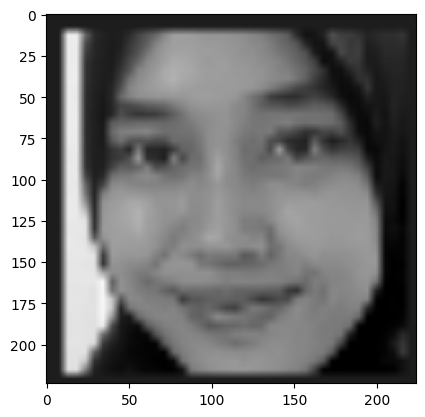

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051031_face_2017051031_20221227_Pulang_10.png
Prediksi 101:  2057051016
Prediksi 50:  2017051051
Probabilitas 101:  0.4852983355522156
Probabilitas 50:  0.8093031048774719




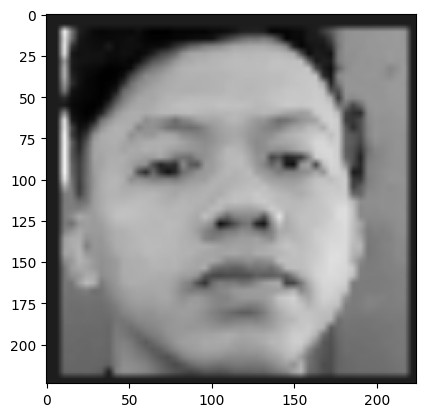

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051020_face_2017051020_20221228_Masuk_47.png
Prediksi 101:  2017051020
Prediksi 50:  2017051020
Probabilitas 101:  0.742184579372406
Probabilitas 50:  0.9673667550086975




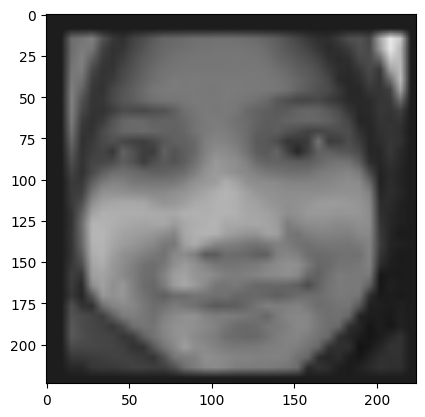

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051051_face_2017051051_20221226_Datang Terlambat_13.png
Prediksi 101:  2017051051
Prediksi 50:  2017051051
Probabilitas 101:  0.9927362203598022
Probabilitas 50:  0.875039279460907




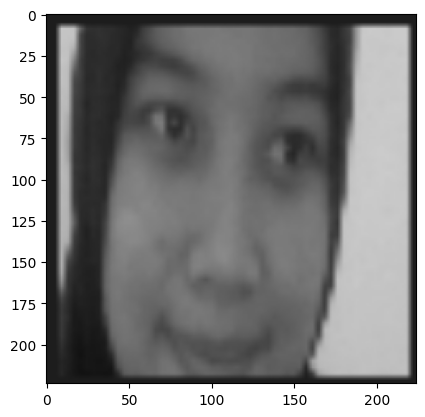

1/1 [==============================] - 0s 21ms/step
Nama File:  2057051006_face_2057051006_20221228_Pulang_49.png
Prediksi 101:  2057051006
Prediksi 50:  1917051029
Probabilitas 101:  0.9978367686271667
Probabilitas 50:  0.9075236916542053




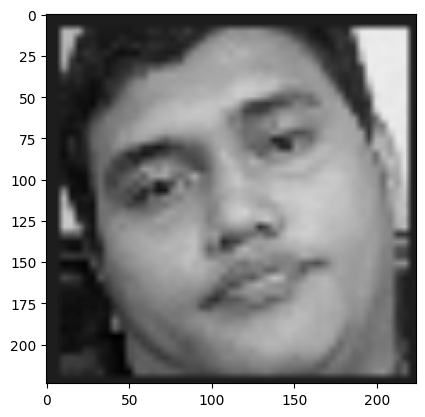

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051033_face_2017051033_20221229_Pulang Cepat_16.png
Prediksi 101:  2017051051
Prediksi 50:  2017051013
Probabilitas 101:  0.5978924632072449
Probabilitas 50:  0.3847043216228485




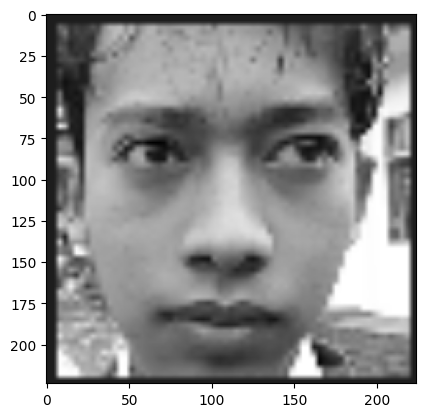

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051026_face_2017051026_20221229_Masuk_24.png
Prediksi 101:  2017051026
Prediksi 50:  2017051079
Probabilitas 101:  0.71919846534729
Probabilitas 50:  0.7856540083885193




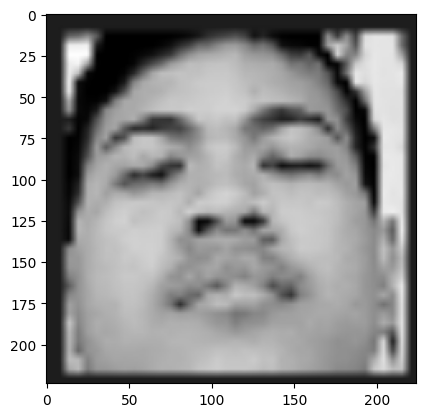

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051081_face_2017051081_20221230_Pulang_42.png
Prediksi 101:  2017051020
Prediksi 50:  2017051020
Probabilitas 101:  0.7608140707015991
Probabilitas 50:  0.872883141040802




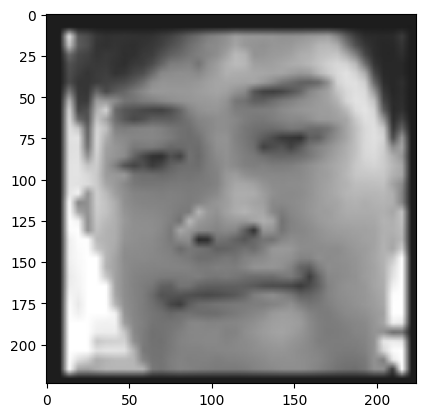

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051044_face_2017051044_20221228_Masuk_72.png
Prediksi 101:  2017051014
Prediksi 50:  2057051003
Probabilitas 101:  0.6436157822608948
Probabilitas 50:  0.2491171658039093




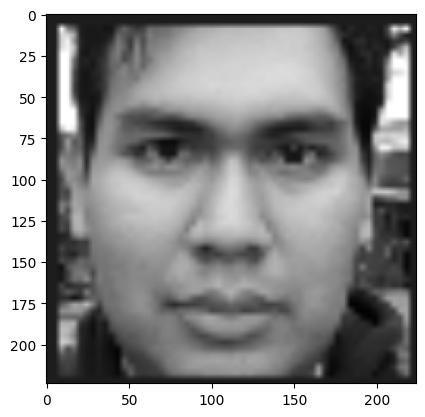

1/1 [==============================] - 0s 24ms/step
Nama File:  2057051016_face_2057051016_20221227_Pulang_36.png
Prediksi 101:  2057051016
Prediksi 50:  2057051016
Probabilitas 101:  0.7453978657722473
Probabilitas 50:  0.9902074933052063




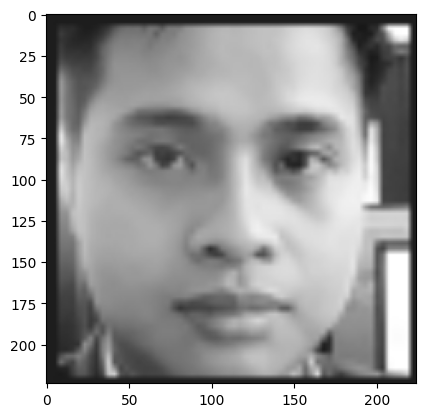

1/1 [==============================] - 0s 23ms/step
Nama File:  1917051033_face_1917051033_20221227_Pulang Cepat_42.png
Prediksi 101:  1917051033
Prediksi 50:  2017051033
Probabilitas 101:  0.5717877149581909
Probabilitas 50:  0.5864986181259155




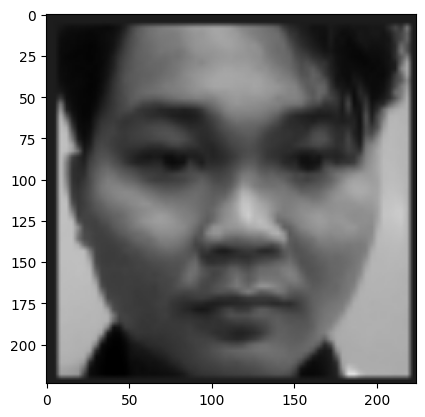

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051004_face_2017051004_20221230_Pulang_5.png
Prediksi 101:  2017051004
Prediksi 50:  2017051004
Probabilitas 101:  0.9998113512992859
Probabilitas 50:  0.9876247644424438




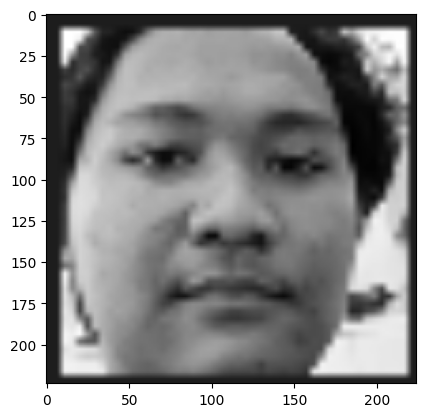

1/1 [==============================] - 0s 23ms/step
Nama File:  1917051047_face_1917051047_20221229_Pulang Cepat_47.png
Prediksi 101:  1917051047
Prediksi 50:  2017051014
Probabilitas 101:  0.8523037433624268
Probabilitas 50:  0.4379831850528717




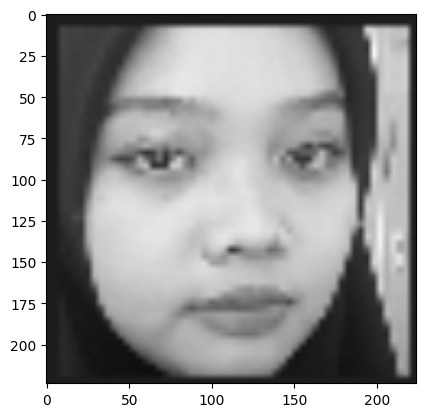

1/1 [==============================] - 0s 23ms/step
Nama File:  2017051079_face_2017051079_20221229_Pulang_95.png
Prediksi 101:  2017051079
Prediksi 50:  2017051079
Probabilitas 101:  0.9906800389289856
Probabilitas 50:  0.9906181693077087




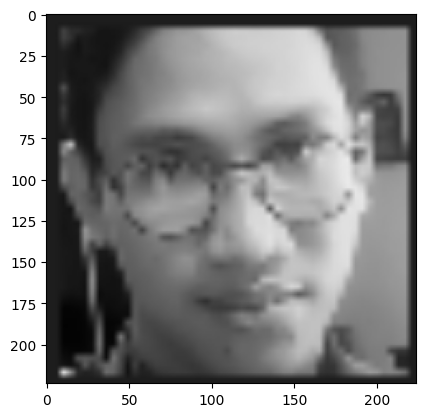

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051014_face_2017051014_20221228_Masuk_92.png
Prediksi 101:  2017051014
Prediksi 50:  2017051014
Probabilitas 101:  0.9052221775054932
Probabilitas 50:  0.9765217304229736




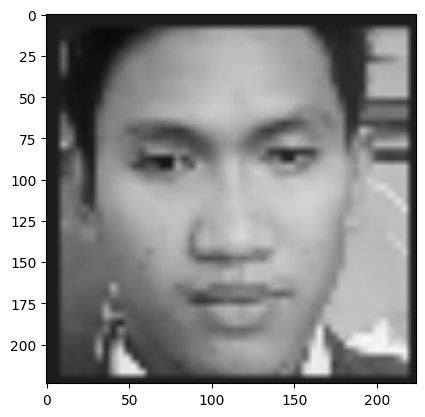

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051014_face_2017051014_20221226_Pulang_58.png
Prediksi 101:  2017051014
Prediksi 50:  2017051014
Probabilitas 101:  0.7885894179344177
Probabilitas 50:  0.9990893602371216




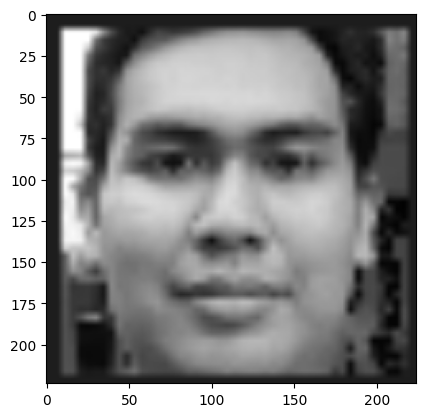

1/1 [==============================] - 0s 21ms/step
Nama File:  2057051016_face_2057051016_20221226_Pulang_50.png
Prediksi 101:  2057051016
Prediksi 50:  2057051016
Probabilitas 101:  0.999700665473938
Probabilitas 50:  0.9987264275550842




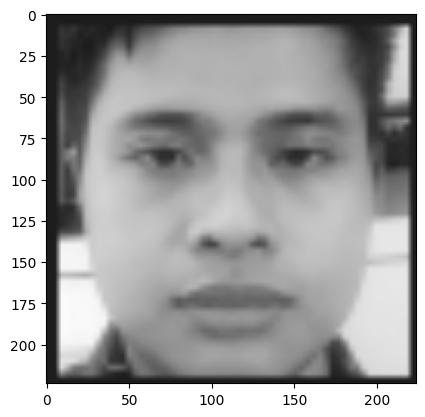

1/1 [==============================] - 0s 22ms/step
Nama File:  1917051033_face_1917051033_20221228_Pulang Cepat_52.png
Prediksi 101:  2057051003
Prediksi 50:  2017051014
Probabilitas 101:  0.6359236240386963
Probabilitas 50:  0.30825164914131165




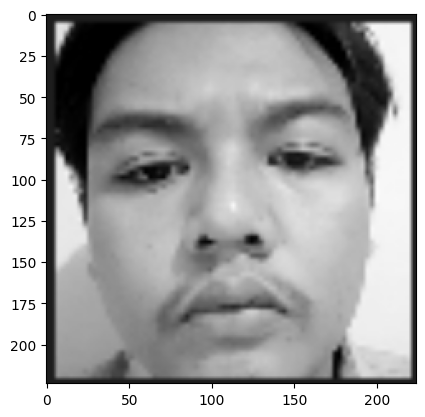

1/1 [==============================] - 0s 22ms/step
Nama File:  1917051041_face_1917051041_20221229_Masuk_43.png
Prediksi 101:  1917051041
Prediksi 50:  1917051041
Probabilitas 101:  0.9943249821662903
Probabilitas 50:  0.9583115577697754




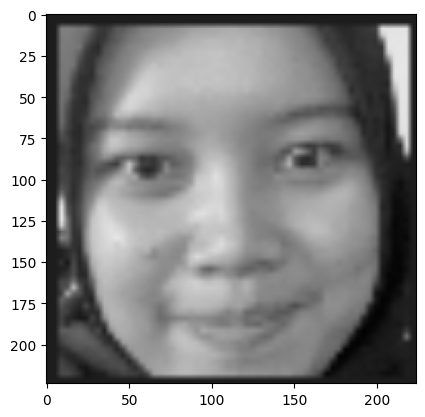

1/1 [==============================] - 0s 23ms/step
Nama File:  2057051006_face_2057051006_20221226_Datang Terlambat_76.png
Prediksi 101:  2017051004
Prediksi 50:  2017051016
Probabilitas 101:  0.3112523555755615
Probabilitas 50:  0.9217956066131592




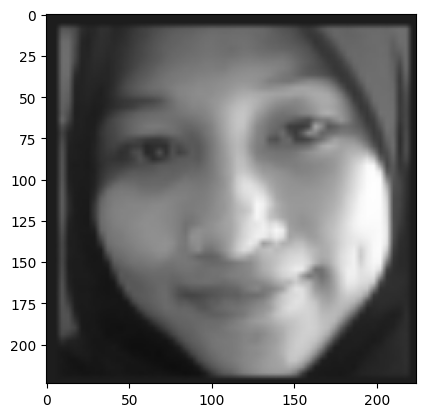

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051013_face_2017051013_20221226_Datang Terlambat_10.png
Prediksi 101:  2017051051
Prediksi 50:  2017051013
Probabilitas 101:  0.546987771987915
Probabilitas 50:  0.4606079161167145


Jumlah prediksi benar 50:  22
Jumlah prediksi salah 50:  16
Jumlah prediksi benar 101:  27
Jumlah prediksi salah 101:  11


In [20]:
conf_resnet50 = np.zeros(shape=(num_classes, num_classes))
conf_resnet101 = np.zeros(shape=(num_classes, num_classes))
labels = train_gen.class_names
count_true_50 = 0
count_false_50 = 0
count_true_101 = 0
count_false_101 = 0
fact_arr = []
predicted_101 = []
predicted_50 = []
for image in os.listdir(testing_path):
  fact = image.split('_')[0]
  fact_arr.append(fact)
  image_path = os.path.join(testing_path, image)

  img = load_img(image_path, target_size=(img_height, img_width))

  # tf.keras.applications.resnetS.preprocess_input(img)

  plt.imshow(img)
  plt.show()

  X = img_to_array(img)

  X = np.expand_dims(X, axis=0)

  images = np.vstack([X])
  # images = tf.keras.applications.resnet50.preprocess_input(images)

  predict_resnet101 = resnet101.predict(images)
  predict_resnet50 = resnet50.predict(images)

  predicted_class_resnet101 = np.argmax(predict_resnet101, axis=1)[0]
  predicted_class_resnet50 = np.argmax(predict_resnet50, axis=1)[0]

  confidential101 = max(predict_resnet101.tolist()[0])
  confidential50 = max(predict_resnet50.tolist()[0])

  # if confidential101 <= 0.3:
  #   predictions_resnet101 = 'unknown'
  # else:
  predictions_resnet101 = labels[predicted_class_resnet101]

  # if confidential50 <= 0.3:
  #   predictions_resnet50 = 'unknown'
  # else:
  predictions_resnet50 = labels[predicted_class_resnet50]
  
  conf_resnet50[class_dict[fact]][class_dict[predictions_resnet50]] += 1
  conf_resnet101[class_dict[fact]][class_dict[predictions_resnet101]] += 1
  
  predicted_101.append(predictions_resnet101)
  predicted_50.append(predictions_resnet50)

  if predictions_resnet50 == fact:
    count_true_50 += 1
  else:
    count_false_50 += 1

  if predictions_resnet101 == fact:
    count_true_101 += 1
  else:
    count_false_101 += 1

  print('Nama File: ', image)
  print('Prediksi 101: ', predictions_resnet101)
  print('Prediksi 50: ', predictions_resnet50)
  print('Probabilitas 101: ', confidential101)
  print('Probabilitas 50: ', confidential50)

  print('\n')


conf_resnet50 = conf_resnet50.astype(int)
conf_resnet101 = conf_resnet101.astype(int)
print("Jumlah prediksi benar 50: ", count_true_50)
print("Jumlah prediksi salah 50: ", count_false_50)
print("Jumlah prediksi benar 101: ", count_true_101)
print("Jumlah prediksi salah 101: ", count_false_101)

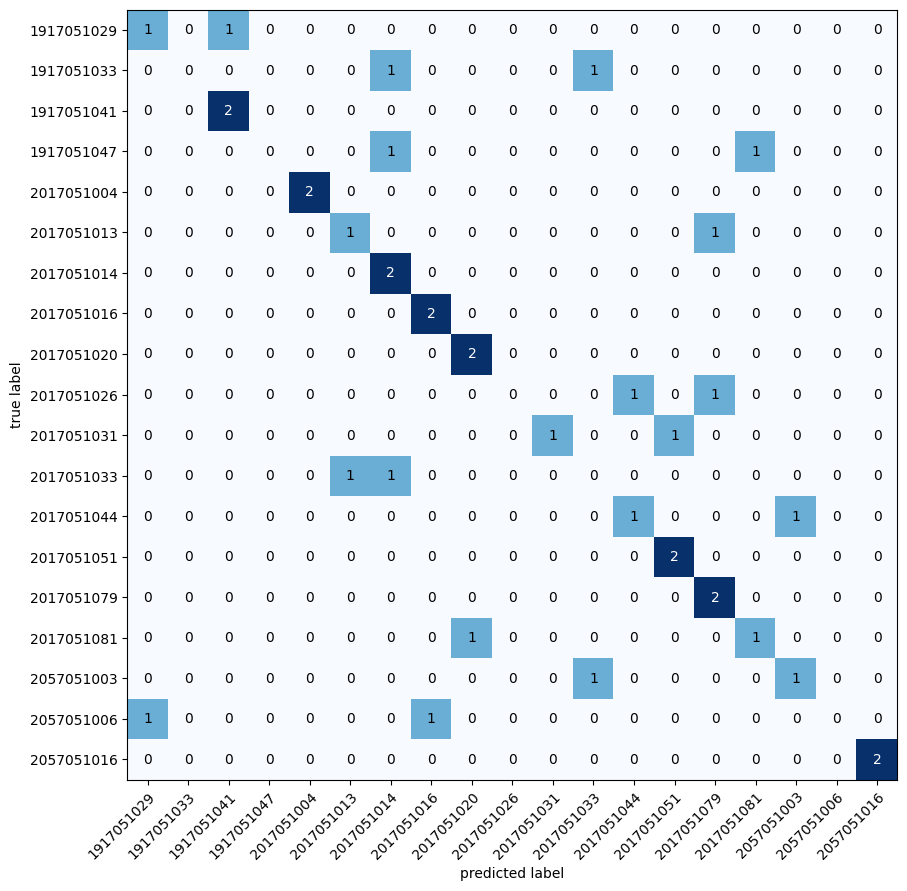

In [21]:
from mlxtend.plotting import plot_confusion_matrix


fig, ax = plot_confusion_matrix(
    conf_mat=conf_resnet50,
    colorbar=False,
    show_absolute=True,
    class_names=class_names,
    figsize=(10, 10)
)

plt.show()

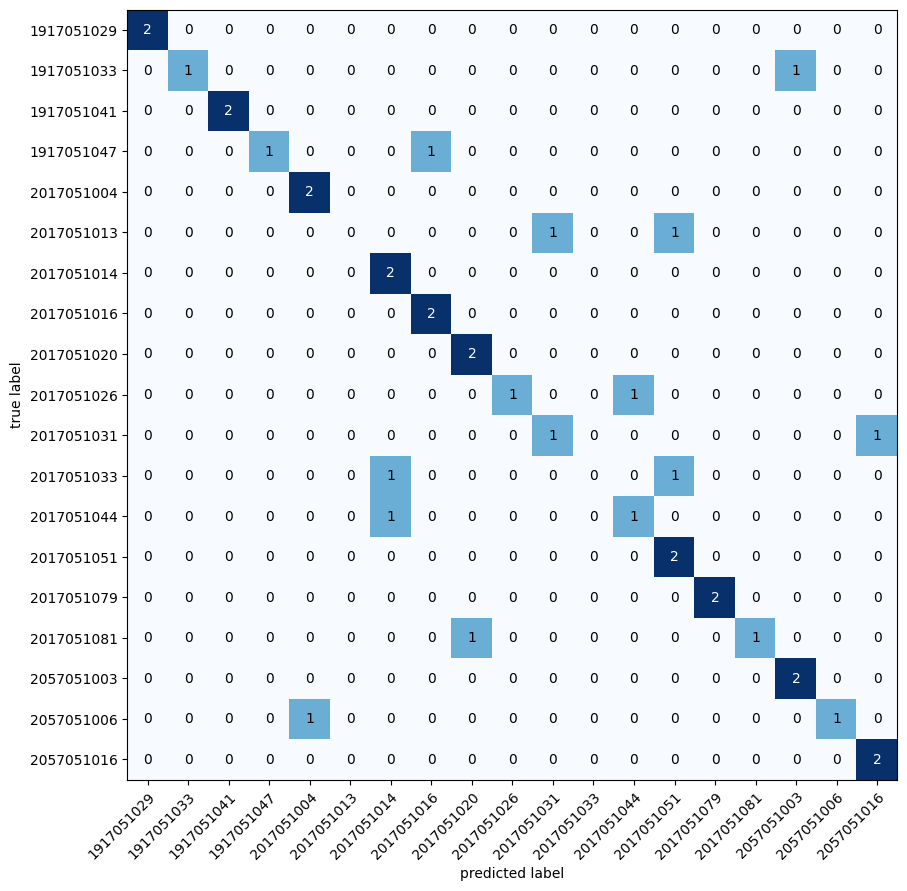

In [22]:
fig, ax = plot_confusion_matrix(
    conf_mat=conf_resnet101,
    colorbar=False,
    show_absolute=True,
    class_names=class_names,
    figsize=(10, 10)
)

plt.show()

In [24]:
from sklearn import metrics
print(metrics.classification_report(fact_arr, predicted_50, target_names=train_gen.class_names))

              precision    recall  f1-score   support

  1917051029       0.50      0.50      0.50         2
  1917051033       0.00      0.00      0.00         2
  1917051041       0.67      1.00      0.80         2
  1917051047       0.00      0.00      0.00         2
  2017051004       1.00      1.00      1.00         2
  2017051013       0.50      0.50      0.50         2
  2017051014       0.40      1.00      0.57         2
  2017051016       0.67      1.00      0.80         2
  2017051020       0.67      1.00      0.80         2
  2017051026       0.00      0.00      0.00         2
  2017051031       1.00      0.50      0.67         2
  2017051033       0.00      0.00      0.00         2
  2017051044       0.50      0.50      0.50         2
  2017051051       0.67      1.00      0.80         2
  2017051079       0.50      1.00      0.67         2
  2017051081       0.50      0.50      0.50         2
  2057051003       0.50      0.50      0.50         2
  2057051006       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print(metrics.classification_report(
    fact_arr, predicted_101, target_names=train_gen.class_names))

              precision    recall  f1-score   support

  1917051029       1.00      1.00      1.00         2
  1917051033       1.00      0.50      0.67         2
  1917051041       1.00      1.00      1.00         2
  1917051047       1.00      0.50      0.67         2
  2017051004       0.67      1.00      0.80         2
  2017051013       0.00      0.00      0.00         2
  2017051014       0.50      1.00      0.67         2
  2017051016       0.67      1.00      0.80         2
  2017051020       0.67      1.00      0.80         2
  2017051026       1.00      0.50      0.67         2
  2017051031       0.50      0.50      0.50         2
  2017051033       0.00      0.00      0.00         2
  2017051044       0.50      0.50      0.50         2
  2017051051       0.50      1.00      0.67         2
  2017051079       1.00      1.00      1.00         2
  2017051081       1.00      0.50      0.67         2
  2057051003       0.67      1.00      0.80         2
  2057051006       1.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
